In [38]:
import math
import numpy as np
import pandas as pd

import tensorflow as tf
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, Add, GlobalAveragePooling1D

import yfinance as yf

In [39]:
def calculate_bollinger_bands(data, window=10, num_of_std=2):
    """Calculate Bollinger Bands"""
    rolling_mean = data.rolling(window=window).mean()
    rolling_std = data.rolling(window=window).std()
    upper_band = rolling_mean + (rolling_std * num_of_std)
    lower_band = rolling_mean - (rolling_std * num_of_std)
    return upper_band, lower_band

def calculate_rsi(data, window=10):
    """Calculate Relative Strength Index"""
    delta = data.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_roc(data, periods=10):
    """Calculate Rate of Change."""
    roc = ((data - data.shift(periods)) / data.shift(periods)) * 100
    return roc


In [40]:
tickers = ['^NSEI']

In [41]:
ticker_data_frames = []
stats = {}
for ticker in tickers:
  
    # Download historical data for the ticker
    data = yf.download(ticker, period="max")




    # Calculate the daily percentage change

    open = data['Open']
    close = data['Close']
    upperClose, lowerClose = calculate_bollinger_bands(close, window=14, num_of_std=2)
    upperOpen, lowerOpen = calculate_bollinger_bands(open, window=14, num_of_std=2)

    #Close Parameters

    widthClose = upperClose - lowerClose
    rsiClose = calculate_rsi(close, window=14)
    rocClose = calculate_roc(close, periods=14)
    percent_change_close = data['Close'].pct_change() * 100
    diffClose = data['Close'].diff(1)

    #Open Parameters 

    widthOpen = upperOpen - lowerOpen
    rsiOpen = calculate_rsi(open, window=14)
    rocOpen = calculate_roc(open, periods=14)
    percent_change_open= data['Open'].pct_change() * 100
    diffOpen = data['Open'].diff(1)


    volume = data['Volume']
    
    # Create a DataFrame for the current ticker and append it to the list
    ticker_df = pd.DataFrame({
        ticker+'_close': close[ticker],
        ticker+'_open': open[ticker],
        ticker+'_widthOpen': widthOpen[ticker],
        ticker+'_widthClose': widthClose[ticker],

        ticker+'_rsiClose': rsiClose[ticker],
        ticker+'_rsiOpen': rsiOpen[ticker],
        ticker+'_rocOpen': rocOpen[ticker],
        ticker+'_rocClose': rocClose[ticker],
        ticker+'_volume': volume[ticker],
        ticker+'_diffOpen': diffOpen[ticker],
        ticker+'_diffClose': diffClose[ticker],
        ticker+'_percent_change_close': percent_change_close[ticker],
        ticker+'_percent_change_open': percent_change_open[ticker]
    }, index=close.index)
    
    MEAN = ticker_df.mean()
    STD = ticker_df.std()

    # Keep track of mean and std
    for column in MEAN.index:
      stats[f"{column}_mean"] = MEAN[column]
      stats[f"{column}_std"] = STD[column]
    
    # Normalize the training features
    ticker_df = (ticker_df - MEAN) / STD

    ticker_data_frames.append(ticker_df)


C:\Users\Rishit\AppData\Local\Temp\ipykernel_1568\3830845851.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, period="max")
[*********************100%***********************]  1 of 1 completed


In [24]:
# Convert the dictionary containing feature statistics to a DataFrame for easier access
stats = pd.DataFrame(stats, index=[0])

# Display the DataFrame to verify its structure
stats.head()


,^NSEI_close_mean,^NSEI_close_std,^NSEI_open_mean,^NSEI_open_std,^NSEI_widthOpen_mean,^NSEI_widthOpen_std,^NSEI_widthClose_mean,^NSEI_widthClose_std,^NSEI_rsiClose_mean,^NSEI_rsiClose_std,...,^NSEI_volume_mean,^NSEI_volume_std,^NSEI_diffOpen_mean,^NSEI_diffOpen_std,^NSEI_diffClose_mean,^NSEI_diffClose_std,^NSEI_percent_change_close_mean,^NSEI_percent_change_close_std,^NSEI_percent_change_open_mean,^NSEI_percent_change_open_std
0,10586.449228,6012.84536,10592.681758,6015.294065,625.72079,437.963643,622.468049,431.515839,54.573043,17.769993,...,209304.033728,206855.426212,4.586939,124.989367,4.577057,118.775859,0.04741,1.317265,0.047697,1.343956


In [25]:
df = pd.concat(ticker_data_frames, axis=1)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)


In [26]:
# Shift the dataframe up by one to align current features with the next step's outcomes
labels = df.shift(-1)

# Remove the last row from both the features and labels to maintain consistent data pairs
df = df.iloc[:-1]
labels = labels.iloc[:-1]


In [27]:
SEQUENCE_LEN = 1  # 2 hours of data at 5-minute intervals

def create_sequences(data, labelsOpen, labelsClose, meanOpen,meanClose, stdOpen,stdClose, sequence_length=SEQUENCE_LEN):
    sequences = []
    labClose = []
    labOpen = []
    data_size = len(data)

    # Loop to create each sequence and its corresponding label
    for i in range(data_size - (sequence_length + sequence_length//2 + 1 )): # Ensure we have data for the label
        if i == 0:
          continue
        sequences.append(data[i:i + sequence_length])  # The sequence of data
        labClose.append([labelsClose[i-1], labelsClose[i + sequence_length//2],meanClose[0], stdClose[0]]) # The label and scaling factors
        labOpen.append([labelsOpen[i-1], labelsOpen[i + sequence_length//2],meanOpen[0], stdOpen[0]])
    return np.array(sequences), np.array(labClose) , np.array(labOpen)

In [28]:
sequences_dict = {}
sequence_labels_open = {}
sequence_labels_close = {}
for ticker in tickers:

    # Extract close and volume data for the ticker
    close = df[ticker+'_close'].values
    open = df[ticker+'_open'].values
    widthOpen = df[ticker+'_widthOpen'].values
    widthClose = df[ticker+'_widthClose'].values
    rsiOpen = df[ticker+'_rsiOpen'].values
    rsiClose = df[ticker+'_rsiClose'].values
    rocOpen = df[ticker+'_rocOpen'].values
    rocClose = df[ticker+'_rocClose'].values

    # rsi = df[ticker+'_rsi'].values
    # roc = df[ticker+'_roc'].values
    volume = df[ticker+'_volume'].values

    diffOpen = df[ticker+'_diffOpen'].values
    diffClose = df[ticker+'_diffClose'].values

    percent_change_close = df[ticker+'_percent_change_close'].values
    percent_change_open = df[ticker+'_percent_change_open'].values

    
    # Combine close and volume data
    ticker_data = np.column_stack((
                                    open,
                                   widthOpen,
                                    rsiOpen,
                                    
                                    rocOpen,
                                    
                                    
                                    diffOpen,
                                
                                   
                                    volume
                                    ))
    
                                   
    
    # Generate sequences
    attributeClose = ticker+"_close"
    attributeOpen = ticker+"_open"

    ticker_sequences, labClose, labOpen = create_sequences(ticker_data,
                                             labels[attributeOpen].values[SEQUENCE_LEN-1:],
                                             labels[attributeClose].values[SEQUENCE_LEN-1:],
                                             
                                             stats[attributeOpen+"_mean"].values,
                                             stats[attributeOpen+"_std"].values,
                                             stats[attributeClose+"_mean"].values,
                                             stats[attributeClose+"_std"].values,
                                             
                                             
                                            
                                             )
    
    sequences_dict[ticker] = ticker_sequences
    sequence_labels_close[ticker] = labClose
    sequence_labels_open[ticker] = labOpen

In [29]:
# Combine data and labels from all tickers
all_sequences = []
all_labelsOpen = []
all_labelsClose = []

for ticker in tickers:
    all_sequences.extend(sequences_dict[ticker])
    all_labelsOpen.extend(sequence_labels_open[ticker])

    all_labelsClose.extend(sequence_labels_close[ticker])
    

# Convert to numpy arrays
all_sequences = np.array(all_sequences)
all_labels_open = np.array(all_labelsOpen)
all_labels_close = np.array(all_labelsClose)
print(all_sequences.shape)


(4370, 1, 6)


In [30]:
np.random.seed(42)
shuffled_indices = np.random.permutation(len(all_sequences))
all_sequences = all_sequences[shuffled_indices]
all_labels_open = all_labels_open[shuffled_indices]
all_labels_close = all_labels_close[shuffled_indices]

train_size = int(len(all_sequences) * 0.9)

# Split sequences
train_sequences = all_sequences[:train_size]
train_labels_open    = all_labels_open[:train_size]
train_labels_close = all_labels_close[:train_size]

other_sequences = all_sequences[train_size:]
other_labels_open    = all_labels_open[train_size:]
other_labels_close = all_labels_close[train_size:]

shuffled_indices = np.random.permutation(len(other_sequences))
other_sequences = other_sequences[shuffled_indices]
other_labels_close = other_labels_close[shuffled_indices]
other_labels_open = other_labels_open[shuffled_indices]

val_size = int(len(other_sequences) * 0.5)

validation_sequences = other_sequences[:val_size]
validation_labels_open = other_labels_open[:val_size]
validation_labels_close = other_labels_close[:val_size]

test_sequences = other_sequences[val_size:]
test_labels_open = other_labels_open[val_size:]
test_labels_close = other_labels_close[val_size:]


In [31]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Attention and Normalization
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = Add()([x, inputs])

    # Feed Forward Part
    y = LayerNormalization(epsilon=1e-6)(x)
    y = Dense(ff_dim, activation="relu")(y)
    y = Dropout(dropout)(y)
    y = Dense(inputs.shape[-1])(y)
    return Add()([y, x])

In [32]:
def build_transformer_model(input_shape, head_size, num_heads, ff_dim, num_layers, dropout=0):
    inputs = Input(shape=input_shape)
    x = inputs
    for _ in range(num_layers):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
    x = GlobalAveragePooling1D()(x)
    x = LayerNormalization(epsilon=1e-6)(x)
    outputs = Dense(1, activation="linear")(x)
    return Model(inputs=inputs, outputs=outputs)

In [33]:
input_shape = train_sequences.shape[1:]
head_size = 256
num_heads = 16
ff_dim = 1024
num_layers = 12
dropout = 0.20
print(input_shape)

model = build_transformer_model(input_shape, head_size, num_heads, ff_dim, num_layers, dropout)
model.summary()

(1, 6)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1, 6)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 1, 6)      │         12 │ input_layer[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 1, 6)      │    110,598 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1, 6)      │          0 │ multi_head_atten… │
│                     │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1, 6)      │         12 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1, 1024)   │      7,168 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 1, 1024)   │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1, 6)      │      6,150 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 1, 6)      │          0 │ dense_1[0][0],    │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1, 6)      │         12 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 1, 6)      │    110,598 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 1, 6)      │          0 │ multi_head_atten… │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1, 6)      │         12 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1, 1024)   │      7,168 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 1, 1024)   │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1, 6)      │      6,150 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 1, 6)      │          0 │ dense_3[0][0],    │
│                     │                   │            │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1, 6)      │         12 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 1, 6)      │    110,598 │ layer_normalizat

 Total params: 1,487,299 (5.67 MB)

 Trainable params: 1,487,299 (5.67 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
def custom_mae_loss(y_true, y_pred):
    y_true_next = tf.cast(y_true[:, 1], tf.float64)  # Extract the true next values, scaled
    y_pred_next = tf.cast(y_pred[:, 0], tf.float64)  # Extract the predicted next values, scaled
    abs_error = tf.abs(y_true_next - y_pred_next)  # Calculate the absolute error
    return tf.reduce_mean(abs_error)  # Return the mean of these errors

def dir_acc(y_true, y_pred):
    mean, std = tf.cast(y_true[:, 2], tf.float64), tf.cast(y_true[:, 3], tf.float64)  # Retrieve scaling factors
    y_true_prev = (tf.cast(y_true[:, 0], tf.float64) * std) + mean  # Un-scale previous true price
    y_true_next = (tf.cast(y_true[:, 1], tf.float64) * std) + mean  # Un-scale next true price
    y_pred_next = (tf.cast(y_pred[:, 0], tf.float64) * std) + mean  # Un-scale predicted next price

    true_change = y_true_next - y_true_prev  # Calculate true change
    pred_change = y_pred_next - y_true_prev  # Calculate predicted change

    correct_direction = tf.equal(tf.sign(true_change), tf.sign(pred_change))  # Check if the signs match
    return tf.reduce_mean(tf.cast(correct_direction, tf.float64))  # Return the mean of correct directions


In [35]:
# Define a callback to save the best model
import matplotlib.pyplot as plt
checkpoint_callback_train = ModelCheckpoint(
    "transformer_train_model.keras",  # Filepath to save the best model
    monitor="dir_acc",  #"loss",  # Metric to monitor
    save_best_only=True,  # Save only the best model
    mode="max",  # Minimize the monitored metric 
    verbose=1,  # Display progress
)

# Define a callback to save the best model
checkpoint_callback_val = ModelCheckpoint(
    "transformer_val_model.keras",  # Filepath to save the best model
    monitor="val_dir_acc", #"val_loss",  # Metric to monitor
    save_best_only=True,  # Save only the best model
    mode="max",  # Minimize the monitored metric 
    verbose=1,  # Display progress
)

def get_lr_callback(batch_size=16, mode='cos', epochs=500, plot=False):
    lr_start, lr_max, lr_min = 0.0001, 0.005, 0.00001  # Adjust learning rate boundaries
    lr_ramp_ep = int(0.30 * epochs)  # 30% of epochs for warm-up
    lr_sus_ep = max(0, int(0.10 * epochs) - lr_ramp_ep)  # Optional sustain phase, adjust as needed

    def lrfn(epoch):
        if epoch < lr_ramp_ep:  # Warm-up phase
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep:  # Sustain phase at max learning rate
            lr = lr_max
        elif mode == 'cos':
            decay_total_epochs, decay_epoch_index = epochs - lr_ramp_ep - lr_sus_ep, epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
        else:
            lr = lr_min  # Default to minimum learning rate if mode is not recognized

        return lr

    if plot:  # Plot learning rate curve if plot is True
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('Epoch')
        plt.ylabel('Learning Rate')
        plt.title('Learning Rate Scheduler')
        plt.show()

    return tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)


In [36]:
BATCH_SIZE = 64  # Number of training examples used to calculate each iteration's gradient
EPOCHS = 100  # Total number of times the entire dataset is passed through the network
model.compile(
    optimizer="adam",  # Optimizer to use
    loss=custom_mae_loss,  # Loss function to minimize
    metrics=[dir_acc]  # Metric to track
)
model.fit(
    train_sequences,  # Training features
    train_labels_close,  # Training labels
    validation_data=(validation_sequences, validation_labels_open, validation_labels_close),  # Validation data
    epochs=EPOCHS,  # Number of epochs to train for
    batch_size=BATCH_SIZE,  # Size of each batch
    shuffle=True,  # Shuffle training data before each epoch
    callbacks=[checkpoint_callback_train, checkpoint_callback_val, get_lr_callback(batch_size=BATCH_SIZE, epochs=EPOCHS)]  # Callbacks for saving models and adjusting learning rate
)



Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
Epoch 1/100


c:\Users\Rishit\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\ops\nn.py:938: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 16, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - dir_acc: 0.4836 - loss: 0.6615
Epoch 1: dir_acc improved from None to 0.48969, saving model to transformer_train_model.keras

Epoch 1: val_dir_acc improved from None to 0.49820, saving model to transformer_val_model.keras
62/62 ━━━━━━━━━━━━━━━━━━━━ 30s 122ms/step - dir_acc: 0.4897 - loss: 0.4475 - val_dir_acc: 0.4982 - val_loss: 790.0700 - learning_rate: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.00026333333333333336.
Epoch 2/100
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - dir_acc: 0.5059 - loss: 0.2844
Epoch 2: dir_acc improved from 0.48969 to 0.50411, saving model to transformer_train_model.keras

Epoch 2: val_dir_acc improved from 0.49820 to 0.56430, saving model to transformer_val_model.keras
62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 110ms/step - dir_acc: 0.5041 - loss: 0.2776 - val_dir_acc: 0.5643 - val_loss: 795.2869 - learning_rate: 2.6333e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.00042666666666666667.
E

c:\Users\Rishit\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\ops\nn.py:938: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 16, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - dir_acc: 0.5509 - loss: 0.1931
Accuracy: 0.5509259104728699


c:\Users\Rishit\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\ops\nn.py:938: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 16, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 161ms/step
R-squared: 0.910742842312818
R-squared: 0.9100862769289138


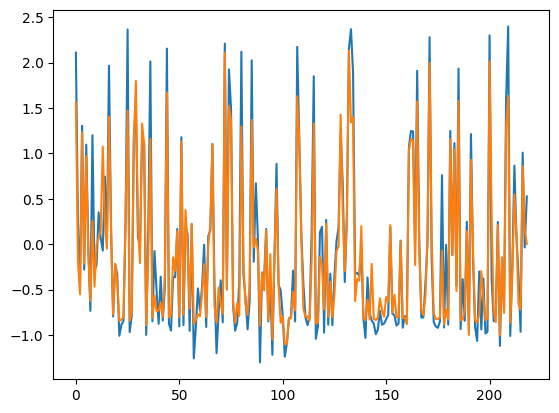

In [37]:
model.load_weights("transformer_val_model.keras")  # Load the best model from the validation phase
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Assuming model is already defined and weights are loaded
accuracy = model.evaluate(test_sequences, test_labels_close)[1]
print(f"Accuracy: {accuracy}")

predictions = model.predict(test_sequences)

# Calculate R-squared value
r2_open = r2_score(test_labels_open[:, 1], predictions[:, 0])
r2_close = r2_score(test_labels_close[:, 1], predictions[:, 0])
print(f"R-squared: {r2_close}" )
print(f"R-squared: {r2_open}")

# Plot actual vs. predicted values

# plt.scatter(test_labels_open[:, 1], predictions[:, 0], alpha=0.5)
# plt.scatter(test_labels_close[:, 1], predictions[:, 0], alpha=0.5)
# plt.plot([min(test_labels_open[:, 1]), max(test_labels_open[:, 1])],
#          [min(test_labels_close[:, 1]), max(test_labels_close[:, 1])], color='red', linestyle='--')
# plt.xlabel('Actual Values')
# plt.ylabel('Predicted Values')
plt.plot(test_labels_open[:,1])
plt.plot( predictions[:, 0])


plt.show()

